In [2]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import operator

import linear_model_tests as lmt
import decision_tree_opt as dto
%reload_ext autoreload
%autoreload 2

lin_mod = lmt.Test()
opt_tree = dto.Parameters()

C:\Users\matti\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
data = pd.read_csv("energydata_complete.csv")
data = data.dropna()
names = ["date","appliance_wh", "light_wh","kitchen_celsius","kitchen_hum_perc",
        "living_celsius","living_hum_perc","laundry_celsius","laundry_hum_perc","office_celsius","office_hum_perc",
         "bathroom_celsius","bathroom_hum_perc","portico_celsius","portico_hum_perc","ironing_celsius","ironing_hum_perc",
         "teen_celsius","teen_hum_perc","parents_celsius","parents_hum_perc","cws_celsius","cws_pressure","cws_hum_perc",
         "cws_wind","cws_visibility","cws_dew_point","rv1","rv2" ]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop(["date"], axis = 1)
data = data.drop_duplicates(data.columns, keep = "last")
data = data.drop(data[(data.appliance_wh > 790)|(data.appliance_wh < 0)].index)
data = data.reset_index()
data = data.drop(["index", "light_wh"], axis = 1)
data.shape

(19718, 27)

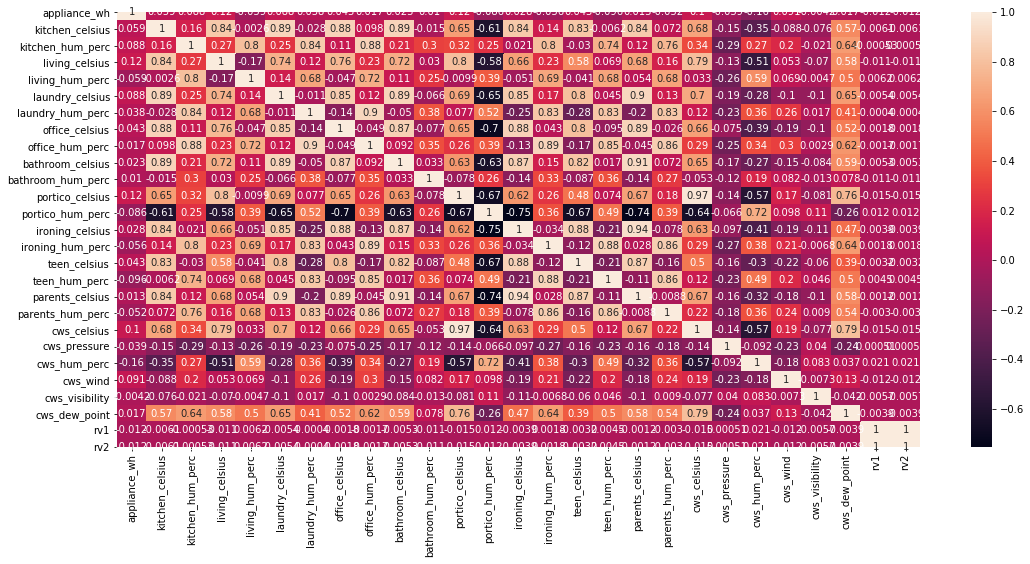

In [88]:
plt.figure(figsize = (18,8))
corr = data.corr()
sns.heatmap(corr, annot = True)

## LINEAR MODEL

In [52]:
X = data.drop("appliance_wh", axis = 1).values
y = data.appliance_wh
y_log = np.log(data.appliance_wh)
X = X.reshape( (len(X), len(X[0])))
y = y.values.reshape( len(y), 1)
print(y.shape, X.shape)

(19718, 1) (19718, 26)


In [53]:
train_size = int(len(X)*0.75)
X_train = X[:train_size]
y_train = y[:train_size]
X_test  = X[train_size:]
y_test  = y[train_size:]
print(train_size, len(X) - train_size)

14788 4930


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression(fit_intercept = True)
model.fit(X_train, y_train)

y_pred = model.predict(X)

print("R^2 = ", round(r2_score(y, y_pred), 5))
print("MSE:", round(mean_squared_error(y, y_pred), 5))

R^2 =  0.14343
MSE: 8559.97229


In [21]:
lasso = lin_mod.lasso(data, X, y)

Reducing features with LASSO 
	 ## Remaining features: 16 
	 ## R^2 after reduction: 0.19809


In [22]:
recursive = lin_mod.recurs_elimin(data, X, y)

Reducing features with Recursive Feature Elimination 
	 ## Remaining features: 13 
	 ## R^2 after reduction: 0.19806


## POLYNOMIAL MODEL

SPLINE: https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
features_polynomial = poly.fit_transform(X_train)

model_2 = LinearRegression(fit_intercept = True)
model_2.fit(features_polynomial, y_train)

y_pred_2 = model_2.predict( poly.transform(X) )

print("R^2 = ", round(r2_score(y, y_pred_2), 5) )

R^2 =  -0.04881


## TREE

In [ ]:
def bias_var(X, y):
    t_size = int(len(X)*0.66)
    X_train = X[:t_size]
    y_train = y[:t_size]
    X_test = X[t_size:]
    y_test = y[t_size:]
    
    preds = []
    # The loop is iterated over a couple of equivalent parameters
    # to reduce the execution time, at the expense of reduction of results 
    for leave, samp in enumerate(range(2, 101)):
        dt = DecisionTreeClassifier(max_leaf_nodes = leave+2, min_samples_split = samp)
        model = dt.fit(X, y)
        preds += [ list(model.predict(X)) ] # every element is y_pred
        
    stats = []    
    for x in range(len(preds)):                           
        dt_variance = np.var(preds[x])
        dt_bias = MSE(y, preds[x]) - dt_variance  # bias^2 = MSE - variance    # (y - np.mean(preds[x]))**2
        acc = accuracy_score(y_true = y, y_pred = preds[x])
        stats += [ (dt_bias.mean(), dt_variance, round(acc, 6)) ]
        
    stats = [ list(x) for x in stats ]
    df = pd.DataFrame(stats, columns = ["bias", "variance", "accuracy"])
    df["bias_plus_var"] = df.bias + df.variance
    
    return df

In [ ]:
stats_df = bias_var(X_tree, y_tree)

In [ ]:
print(stats_df.loc[stats_df.bias_plus_var == min(stats_df.bias_plus_var)])
print()
print(stats_df.loc[stats_df.accuracy == max(stats_df.accuracy)])

To assess the parameter of the Tree Classifier, we performed a simulation to see how to set the ```max_leaf_nodes``` parameter in such a way that the the sum of bias$^2$ and Variance is minimized. This led to the value of ```39```, but we have seen a decrease in the accuracy of the model from 0.69 to 0.26.
<p>
*****The assement on ensemble method that is more suitable for this instance was made on the bias and variance value of the actual model, without the simulation implemented: since the variance is far low than the bias. <p>

```python
stats_df = opt_tree.bias_var(X_tree, y_tree) # long to be executed
print(stats_df.loc[stats_df.bias_plus_var == min(stats_df.bias_plus_var)])
print()
print(stats_df.loc[stats_df.accuracy == max(stats_df.accuracy)])

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize = (9, 5))

ax1.set_xlabel('Model Complexity')
ax1.set_ylabel('Bias$^2$ + Variance', color = "#3DA5D9")
ax1.plot(range(len(stats_df)), stats_df.bias_plus_var, color = "#3DA5D9", linewidth = 1, alpha = 0.7)
ax1.plot(range(len(stats_df)), stats_df.variance, color = "#DB504A", linewidth = 1, alpha = 0.7)

ax1.tick_params(axis = 'y')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color = "#EA7317")
ax2.plot(range(len(stats_df)), stats_df.accuracy, color = "#EA7317", linewidth = 1, alpha = 0.7)
ax2.tick_params(axis = 'y')
fig.tight_layout()
plt.savefig('Bias_variance_accuracy.png', dpi = 300)
```

In [95]:
y_train_tree = y_log[:train_size]
y_test_tree  = y_log[train_size:]

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

decisiontree = DecisionTreeRegressor(random_state = 652)
model_tree = decisiontree.fit(X_train, y_train_tree)
tree_pred = model_tree.predict(X)

print("MAE:", mean_absolute_error(y_log, tree_pred))
print("MSE:", mean_squared_error(y_log, tree_pred))
print("Variance:", np.var(tree_pred))
print("Accuracy:", 100 - np.mean((abs(tree_pred - y_log)/y_log)*100) )

importance = dict(zip(data.drop("appliance_wh", axis = 1).columns, list(model_tree.feature_importances_)))
importance = pd.DataFrame(importance, index = range(len(list(model_tree.feature_importances_))))
importance.loc[25:].T.sort_values(25, ascending = False).rename(columns = {25:"values"}).head()

MAE: 0.20855459352635164
MSE: 0.28102625631024114
Variance: 0.5676067424205106
Accuracy: 95.08453241554064


,values
living_celsius,0.101599
parents_hum_perc,0.075794
bathroom_hum_perc,0.058338
laundry_celsius,0.055611
portico_celsius,0.052908


## PARAMETER TUNING

In [67]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
print("Parameteres currently used:")
pprint(decisiontree.get_params())

ccp_alpha = list(range(100))        # 1
criterion = ["mse", "friedman_mse", "mae"]        # "friedman_mse"
max_depth = list(range(1,50)) # 2
max_features = ["auto", "sqrt", "log2"] + list(range(1,X.shape[1]))        # 1
max_leaf_nodes = list(range(2,50)) # 3
min_impurity_decrease = np.arange(0.0,1.0, 0.001)        # 0.011
min_impurity_split = np.arange(0.0,1.0, 0.001)        # 0.485
min_samples_leaf = np.arange(0,1,0.1)        # 0.2
min_samples_split = list(range(2,50))        # 49
min_weight_fraction_leaf = np.arange(0,1,0.1)        # 0.2
random_state = list(range(0,1500))        # 652
splitter = ["best", "random"]        # "random"

random_grid = {"criterion":criterion}
tree_random = GridSearchCV(decisiontree, random_grid, n_jobs = -1, cv = 2)
tree_random.fit(X_train, y_train_tree)
tree_model = tree_random.best_estimator_
print()
print (tree_random.best_score_, tree_random.best_params_)

Parameteres currently used:
{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 652,
 'splitter': 'best'}

-0.9879138233205508 {'criterion': 'friedman_mse'}


In [49]:
from sklearn.metrics import mean_absolute_error
tree_tuned = DecisionTreeRegressor(random_state= 981, criterion = "friedman_mse", min_samples_split = 2,
                                   min_impurity_decrease = 0.011, min_impurity_split = 0.485,
                                   ccp_alpha = 1, min_weight_fraction_leaf = 0.2, min_samples_leaf = 0.2,
                                   max_depth = 2, max_features = 1, max_leaf_nodes = 3, splitter = "random")

model_tuned = tree_tuned.fit(X_train, y_train_tree)
tuned_pred = model_tuned.predict(X)

print("MAE:", mean_absolute_error(y_log, tuned_pred))
print("MSE:", mean_squared_error(y_log, tuned_pred))
print("Variance:", np.var(tuned_pred))
print("Accuracy:", 100 - np.mean((abs(tuned_pred - y_log)/y_log)*100) )

MAE: 0.4857723747086171
MSE: 0.42597604990179444
Variance: 7.888609052210118e-31
Accuracy: 88.95556322997817


In [63]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_tuned, loss = "linear", random_state = 981)
boost_model = adaboost.fit(X_train, y_train_tree)
adaboost_pred = boost_model.predict(X)

print("MAE:", mean_absolute_error(y_log, adaboost_pred))
print("MSE:", mean_squared_error(y_log, adaboost_pred))
print("Variance:", np.var(adaboost_pred))
print("Accuracy:", 100 - np.mean((abs(adaboost_pred - y_log)/y_log)*100) )

MAE: 0.5845678095139968
MSE: 0.49682078135551294
Variance: 7.888609052210118e-31
Accuracy: 85.95447578097351


In [61]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_tuned)
bagg_model = bagged.fit(X_train, y_train_tree)
bagg_pred = bagg_model.predict(X)

print("MAE:", mean_absolute_error(y_log, bagg_pred))
print("MSE:", mean_squared_error(y_log, bagg_pred))
print("Variance:", np.var(bagg_pred))
print("Accuracy:", 100 - np.mean((abs(bagg_pred - y_log)/y_log)*100) )

MAE: 0.4868888334686278
MSE: 0.4258886303938043
Variance: 7.888609052210118e-31
Accuracy: 88.91794523860162
